In [51]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
%autoreload 2

from copy import deepcopy
import logging
import math
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import sys

sys.path.append('../')
from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

plt.style.use('../sci_style.py')

# Load Data

In [18]:
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [19]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [20]:
variables = ['spikeTimes']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
spike_times = session_vars['spikeTimes']

In [21]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [22]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [23]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

# Induction Times

In [46]:
induction_erps = []
for t in trajectory_times:
    if t - leadup*dt > session_info['drugStart'][0] and t + post*dt < eyes_close:
        t = int(t/dt)
        induction_erps.append(lfp[t - leadup:t + post])

In [47]:
induction_erps = np.array(induction_erps)
# induction_erps = (induction_erps - induction_erps.mean(axis=(, 1)))/induction_erps.std(axis=(0, 1))


In [48]:
area = 'vlPFC'
if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

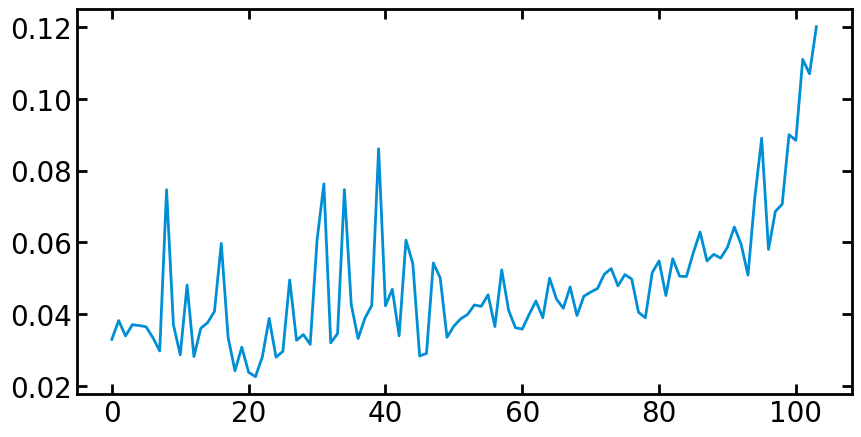

In [50]:
plt.plot(np.abs(induction_erps[:, leadup:leadup + 1000, unit_indices]).mean(axis=(1, 2)))

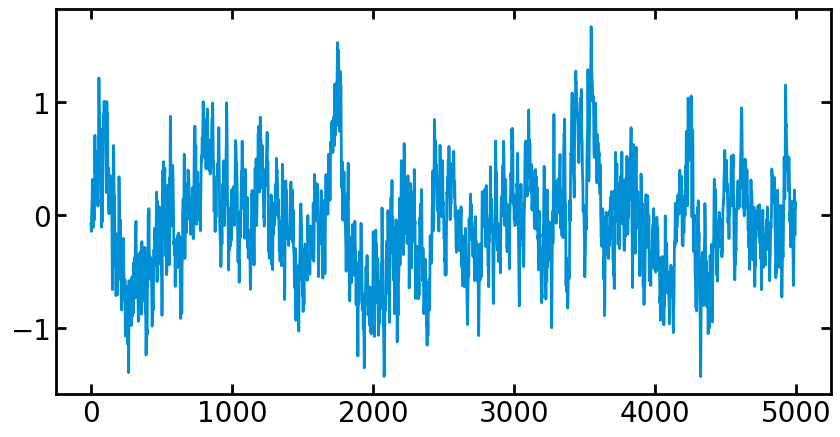

In [33]:
plt.plot(induction_erps[0][:, unit_indices[0]])

# ERPs

In [26]:
# areas = np.unique(electrode_info['area'])
areas = ['vlPFC', 'FEF', '7b', 'CPB']

In [27]:
leadup = 2500
post = 2500

In [28]:
wake_bounds = [0, session_info['drugStart'][0]]
anesthesia_bounds = [eyes_close, session_info['drugEnd'][1]]

In [29]:
trajectory_times = tone_on

wake_erps = []
anesthesia_erps = []

for t in trajectory_times:
    if t - leadup*dt > wake_bounds[0] and t + post*dt < wake_bounds[1]:
        t = int(t/dt)
        wake_erps.append(lfp[t - leadup:t + post])
    elif t - leadup*dt > anesthesia_bounds[0] and t + post*dt < anesthesia_bounds[1]:
        t = int(t/dt)
        anesthesia_erps.append(lfp[t - leadup:t + post])
wake_erps = np.array(wake_erps)
anesthesia_erps = np.array(anesthesia_erps)

  0%|          | 0/4 [00:00<?, ?it/s]

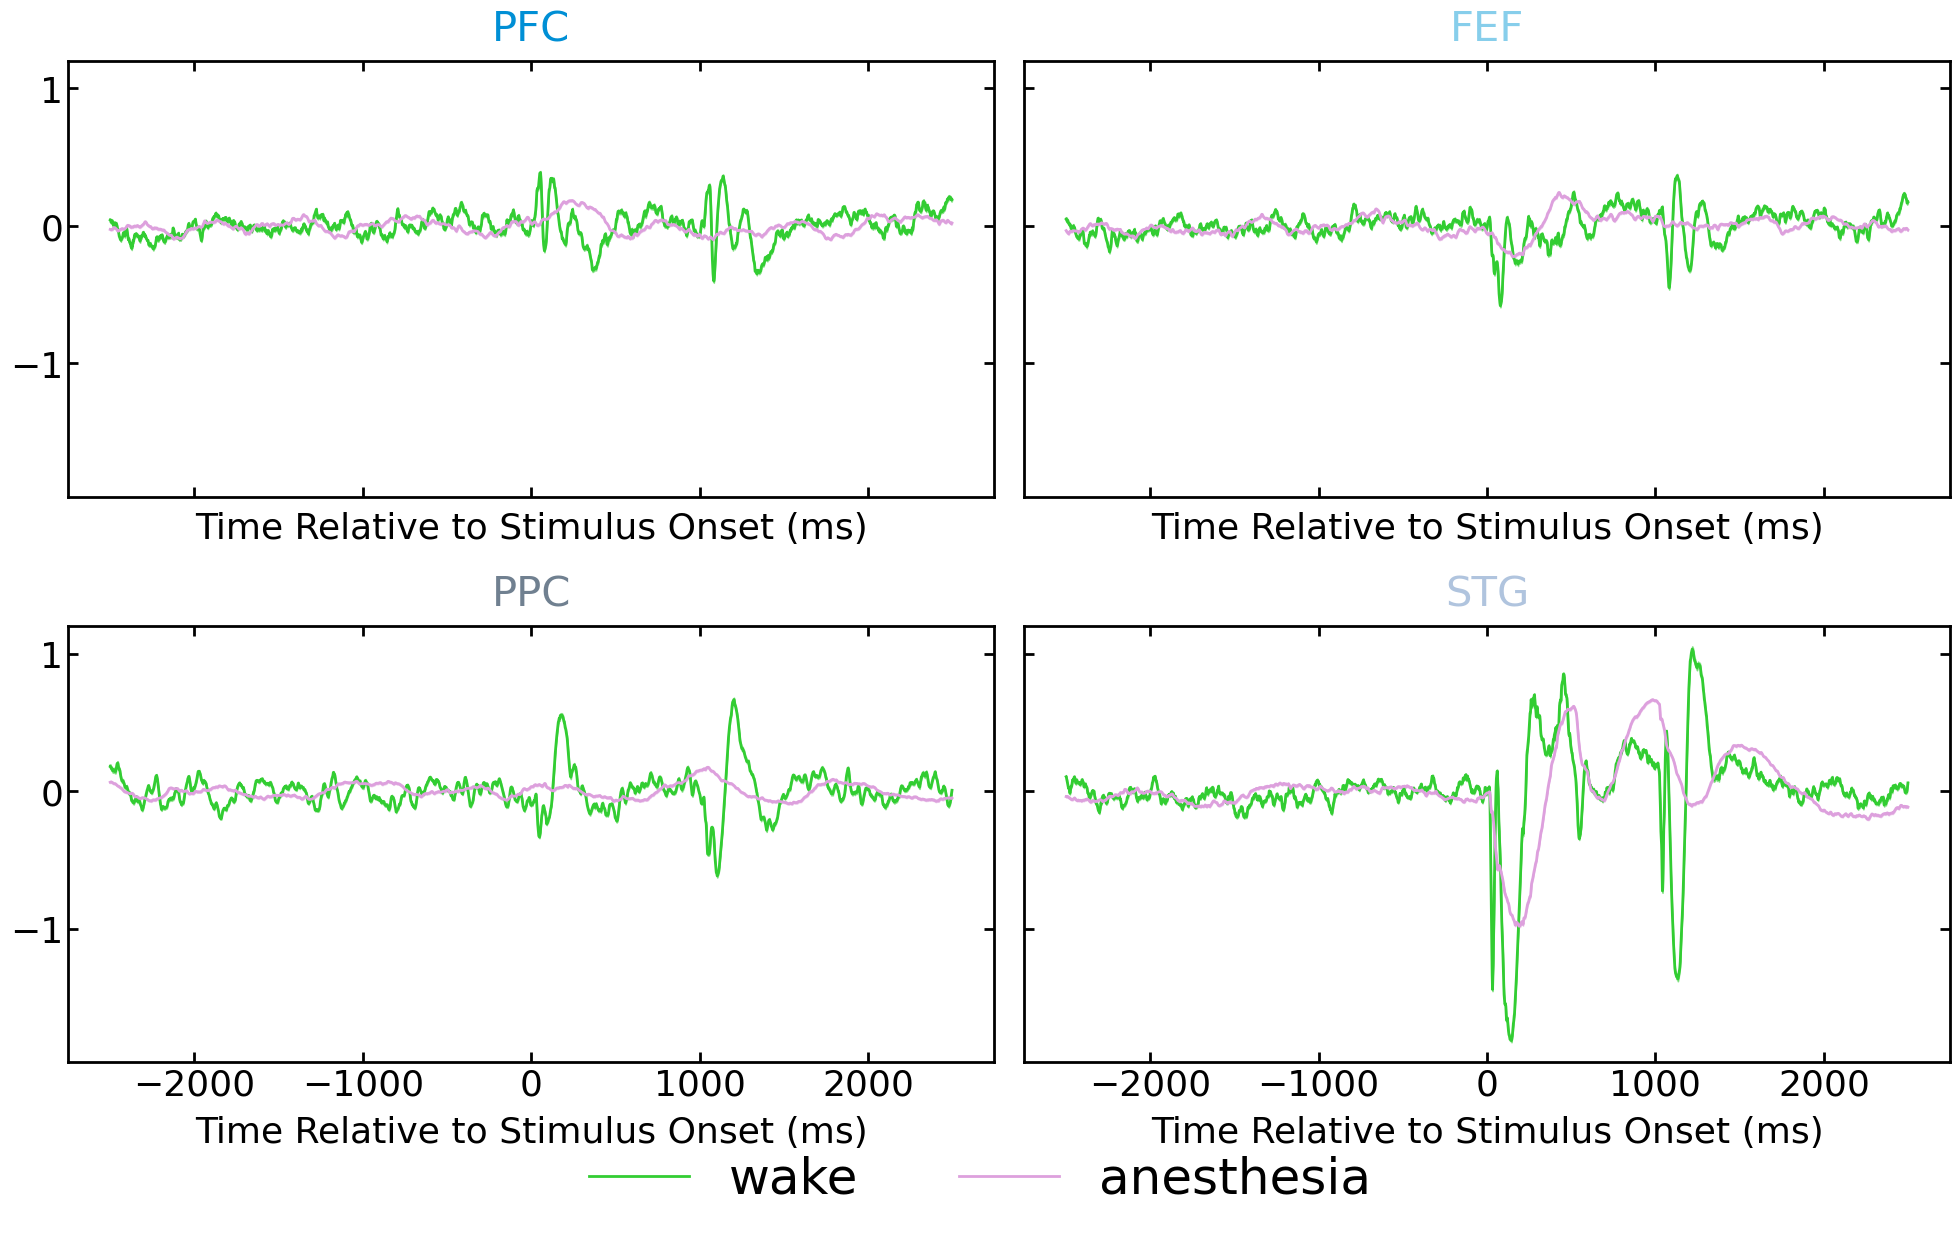

In [30]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'purple'
}
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'all'
}

time_vals = np.arange(-leadup, post)
fig, axs = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)
for i, area in tqdm(enumerate(areas), total=len(areas)):
    
    ax = axs[int(i/2)][i % 2]
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
    wake_erp_mean = wake_erps[:, :, unit_indices].mean(axis=(0, 2))
    wake_erp_se = wake_erps[:, :, unit_indices].std(axis=(0, 2))/np.sqrt(wake_erps.shape[0]*len(unit_indices))
    lns = []
    lns += ax.plot(time_vals, wake_erp_mean, c='limegreen', label='wake')
    ax.fill_between(time_vals, wake_erp_mean - wake_erp_se, wake_erp_mean + wake_erp_se, color='limegreen', alpha=0.5)
    
    anesthesia_erp_mean = anesthesia_erps[:, :, unit_indices].mean(axis=(0, 2))
    anesthesia_erp_se = anesthesia_erps[:, :, unit_indices].std(axis=(0, 2))/np.sqrt(anesthesia_erps.shape[0]*len(unit_indices))
    lns += ax.plot(time_vals, anesthesia_erp_mean, c='plum', label='anesthesia')
    ax.fill_between(time_vals, anesthesia_erp_mean - anesthesia_erp_se, anesthesia_erp_mean + anesthesia_erp_se, color='plum', alpha=0.5)
    
    
    ax.set_title(area_labels[area], c=area_colors[area], fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=26)
    ax.tick_params(axis='both', which='minor', labelsize=26)
    ax.set_title(area_labels[area], c=area_colors[area], fontsize=30)
    ax.set_xlabel('Time Relative to Stimulus Onset (ms)', fontsize=26)
fig.legend(lns, [ln.get_label() for ln in lns], fontsize=36, ncol=2, bbox_to_anchor=(0.5, 0), loc='center')
plt.tight_layout()
plt.show()

# Multiple Sessions

In [5]:
leadup = 2500
post = 2500
session_rets = {}
for session in ['MrJones-Anesthesia-20160109-01', 'Mary-Anesthesia-20160912-02']:
    #---------------------
    # LOAD DATA
    #---------------------
    all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

    eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

    section_times = dict( 
            wake=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            anesthesia=(eyes_close, session_info['drugEnd'][1]),
            recovery=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())

    tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
    tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]
    
    #---------------------
    # ANALYZE
    #---------------------

    wake_bounds = [0, session_info['drugStart'][0]]
    anesthesia_bounds = [eyes_close, session_info['drugEnd'][1]]

    trajectory_times = tone_on

    wake_erps = []
    anesthesia_erps = []

    for t in trajectory_times:
        if t - leadup*dt > wake_bounds[0] and t + post*dt < wake_bounds[1]:
            t = int(t/dt)
            wake_erps.append(lfp[t - leadup:t + post])
        elif t - leadup*dt > anesthesia_bounds[0] and t + post*dt < anesthesia_bounds[1]:
            t = int(t/dt)
            anesthesia_erps.append(lfp[t - leadup:t + post])
    wake_erps = np.array(wake_erps)
    anesthesia_erps = np.array(anesthesia_erps)
    
    # normalize whole array
#     wake_erps_normed = (wake_erps - wake_erps.mean())/wake_erps.std()
#     anesthesia_erps_normed = (anesthesia_erps - anesthesia_erps.mean())/anesthesia_erps.std()
    
    # normalize each channel
    wake_erps_normed = (wake_erps - wake_erps.mean(axis=(0, 1)))/wake_erps.std(axis=(0, 1))
    anesthesia_erps_normed = (anesthesia_erps - anesthesia_erps.mean(axis=(0, 1)))/anesthesia_erps.std(axis=(0, 1))
    
    session_rets[session] = dict(
        wake_erps_full=wake_erps,
        anesthesia_erps_full=anesthesia_erps,
        wake_erps=wake_erps_normed,
        anesthesia_erps=anesthesia_erps_normed,
        electrode_info=electrode_info,
        spike_times=spike_times,
        unit_info=unit_info,
        tone_on=tone_on,
        tone_off=tone_off,
        wake_bounds=wake_bounds,
        anesthesia_bounds=anesthesia_bounds,
    )

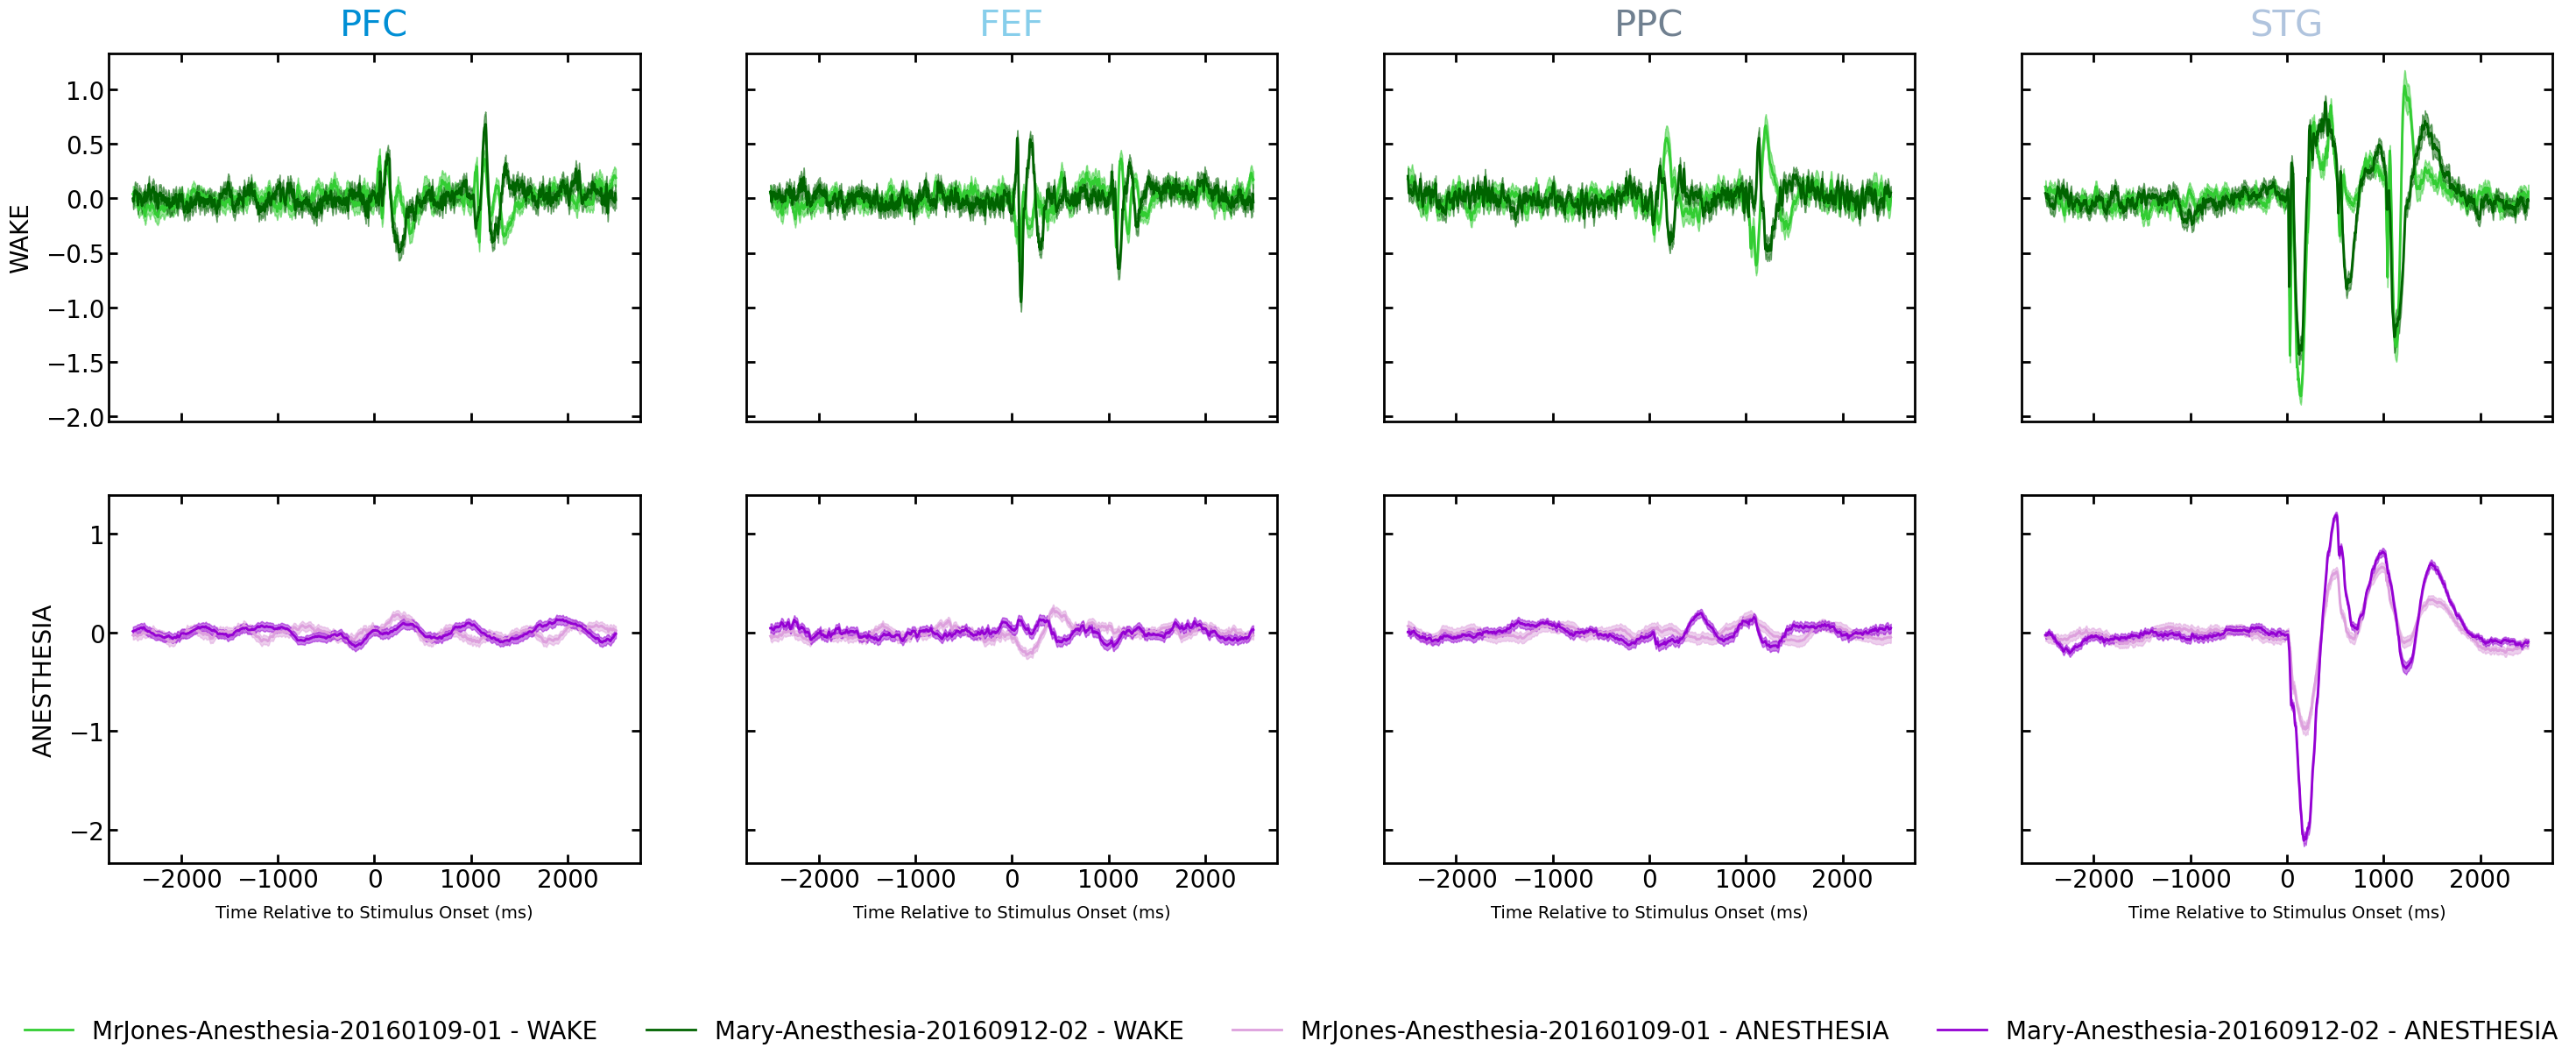

In [8]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'purple'
}
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'all'
}

fig, axs = plt.subplots(2, 4, figsize=(36, 12), sharex=True, sharey='row')

wake_colors = ['limegreen', 'darkgreen']
anesthesia_colors = ['plum', 'darkviolet']

time_vals = np.arange(-leadup, post)
lns = []
for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):
    ax = axs[0][i % 4]
    for j, session in enumerate(session_rets.keys()):
        area_erp = session_rets[session]['wake_erps'][:, :, np.where(session_rets[session]['electrode_info']['area'] == area)[0]]
#         erp_mean = area_erp.mean(axis=(0, 2))
#         erp_se = area_erp.std(axis=(0, 2))/(np.sqrt(area_erp.shape[0]*area_erp.shape[2]))
        erp_mean = area_erp.mean(axis=2).mean(axis=0)
        erp_se = area_erp.mean(axis=2).std(axis=0)/(np.sqrt(area_erp.shape[0]))
        ln = ax.plot(time_vals, erp_mean, label=f"{session} - WAKE", c=wake_colors[j])
        if i == 0:
            lns += ln
            ax.set_ylabel('WAKE', fontsize=20)
        ax.fill_between(time_vals, erp_mean - erp_se, erp_mean + erp_se, color=wake_colors[j], alpha=0.5)
    ax.set_title(area_labels[area], c=area_colors[area], fontsize=30)
#     ax.legend()
    
for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):
    ax = axs[1][i % 4]
    for j, session in enumerate(session_rets.keys()):
        area_erp = session_rets[session]['anesthesia_erps'][:, :, np.where(session_rets[session]['electrode_info']['area'] == area)[0]]
#         erp_mean = area_erp.mean(axis=(0, 2))
#         erp_se = area_erp.std(axis=(0, 2))/(np.sqrt(area_erp.shape[0]*area_erp.shape[2]))
        erp_mean = area_erp.mean(axis=2).mean(axis=0)
        erp_se = area_erp.mean(axis=2).std(axis=0)/(np.sqrt(area_erp.shape[0]))
        ln = ax.plot(time_vals, erp_mean, label=f"{session} - ANESTHESIA", c=anesthesia_colors[j])
        if i == 0:
            lns += ln
            ax.set_ylabel('ANESTHESIA', fontsize=20)
        ax.fill_between(time_vals, erp_mean - erp_se, erp_mean + erp_se, color=anesthesia_colors[j], alpha=0.5)
#     ax.legend()
    ax.set_xlabel('Time Relative to Stimulus Onset (ms)', fontsize=14)
fig.legend(lns, [ln.get_label() for ln in lns], fontsize=20, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=4)
plt.show()

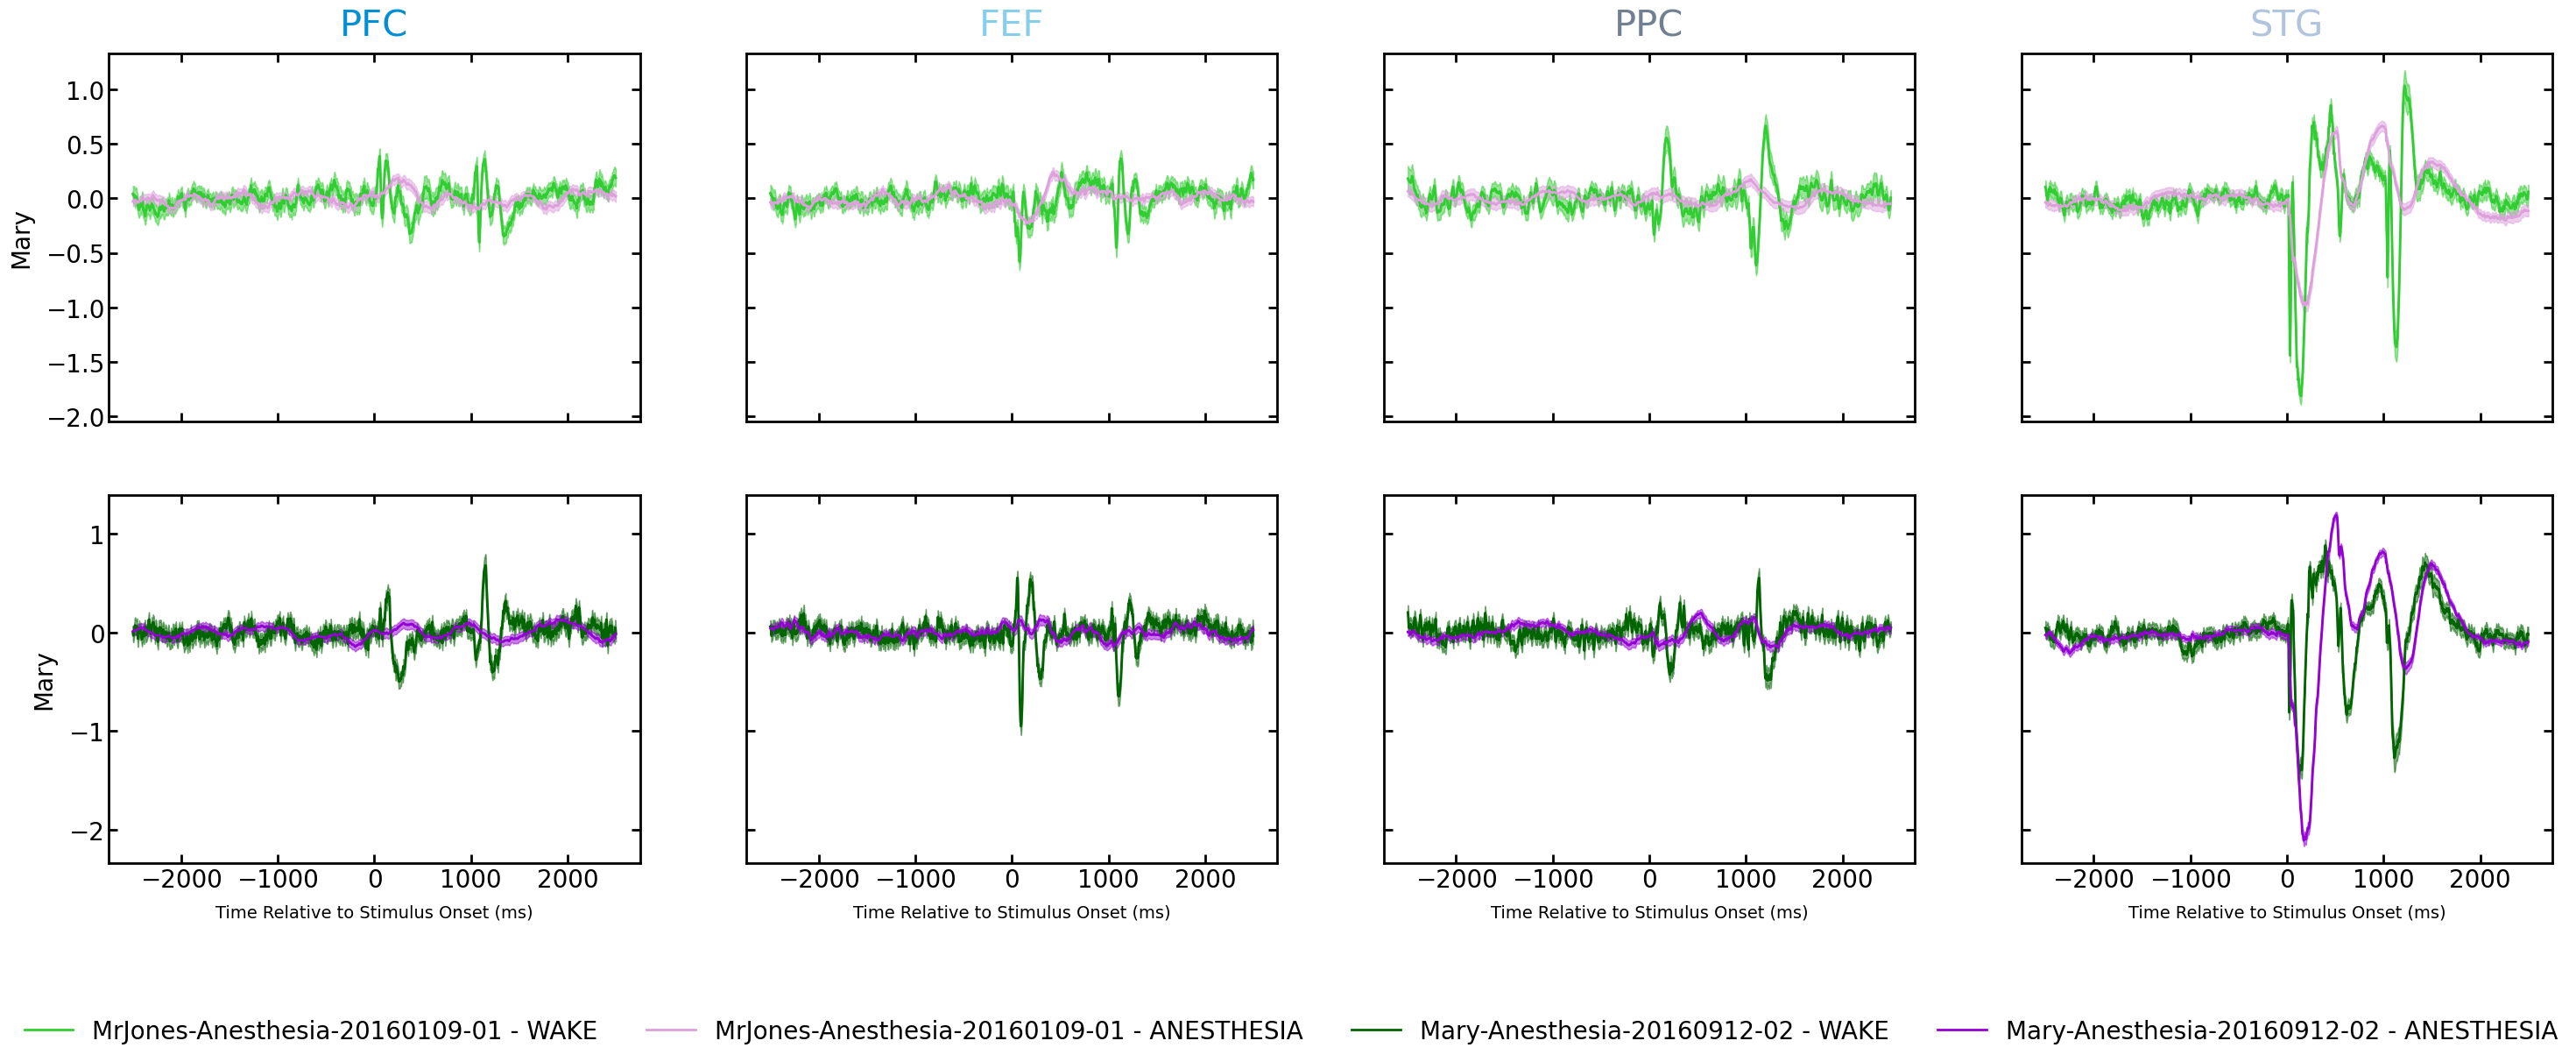

In [53]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'purple'
}
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'all'
}

fig, axs = plt.subplots(2, 4, figsize=(36, 12), sharex=True, sharey='row')

wake_colors = ['limegreen', 'darkgreen']
anesthesia_colors = ['plum', 'darkviolet']

time_vals = np.arange(-leadup, post)
lns = []
for j, session in enumerate(session_rets.keys()):
    for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):
        ax = axs[j][i]
        area_erp = session_rets[session]['wake_erps'][:, :, np.where(session_rets[session]['electrode_info']['area'] == area)[0]]
#         erp_mean = area_erp.mean(axis=(0, 2))
#         erp_se = area_erp.std(axis=(0, 2))/(np.sqrt(area_erp.shape[0]*area_erp.shape[2]))
        erp_mean = area_erp.mean(axis=2).mean(axis=0)
        erp_se = area_erp.mean(axis=2).std(axis=0)/(np.sqrt(area_erp.shape[0]))
        ln = ax.plot(time_vals, erp_mean, label=f"{session} - WAKE", c=wake_colors[j])
        if i == 0:
            lns += ln
            ax.set_ylabel('MrJones', fontsize=20)
        ax.fill_between(time_vals, erp_mean - erp_se, erp_mean + erp_se, color=wake_colors[j], alpha=0.5)
        if j == 0:
            ax.set_title(area_labels[area], c=area_colors[area], fontsize=30)

        area_erp = session_rets[session]['anesthesia_erps'][:, :, np.where(session_rets[session]['electrode_info']['area'] == area)[0]]
#         erp_mean = area_erp.mean(axis=(0, 2))
#         erp_se = area_erp.std(axis=(0, 2))/(np.sqrt(area_erp.shape[0]*area_erp.shape[2]))
        erp_mean = area_erp.mean(axis=2).mean(axis=0)
        erp_se = area_erp.mean(axis=2).std(axis=0)/(np.sqrt(area_erp.shape[0]))
    
        ln = ax.plot(time_vals, erp_mean, label=f"{session} - ANESTHESIA", c=anesthesia_colors[j])
        if i == 0:
            lns += ln
            ax.set_ylabel('Mary', fontsize=20)
        ax.fill_between(time_vals, erp_mean - erp_se, erp_mean + erp_se, color=anesthesia_colors[j], alpha=0.5)
#     ax.legend()
        if j == 1:
            ax.set_xlabel('Time Relative to Stimulus Onset (ms)', fontsize=14)
fig.legend(lns, [ln.get_label() for ln in lns], fontsize=20, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=4)
plt.show()

In [146]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
if session == 'MrJones-Anesthesia-20160109-01':
    session_num = 0
else:
    session_num = 1

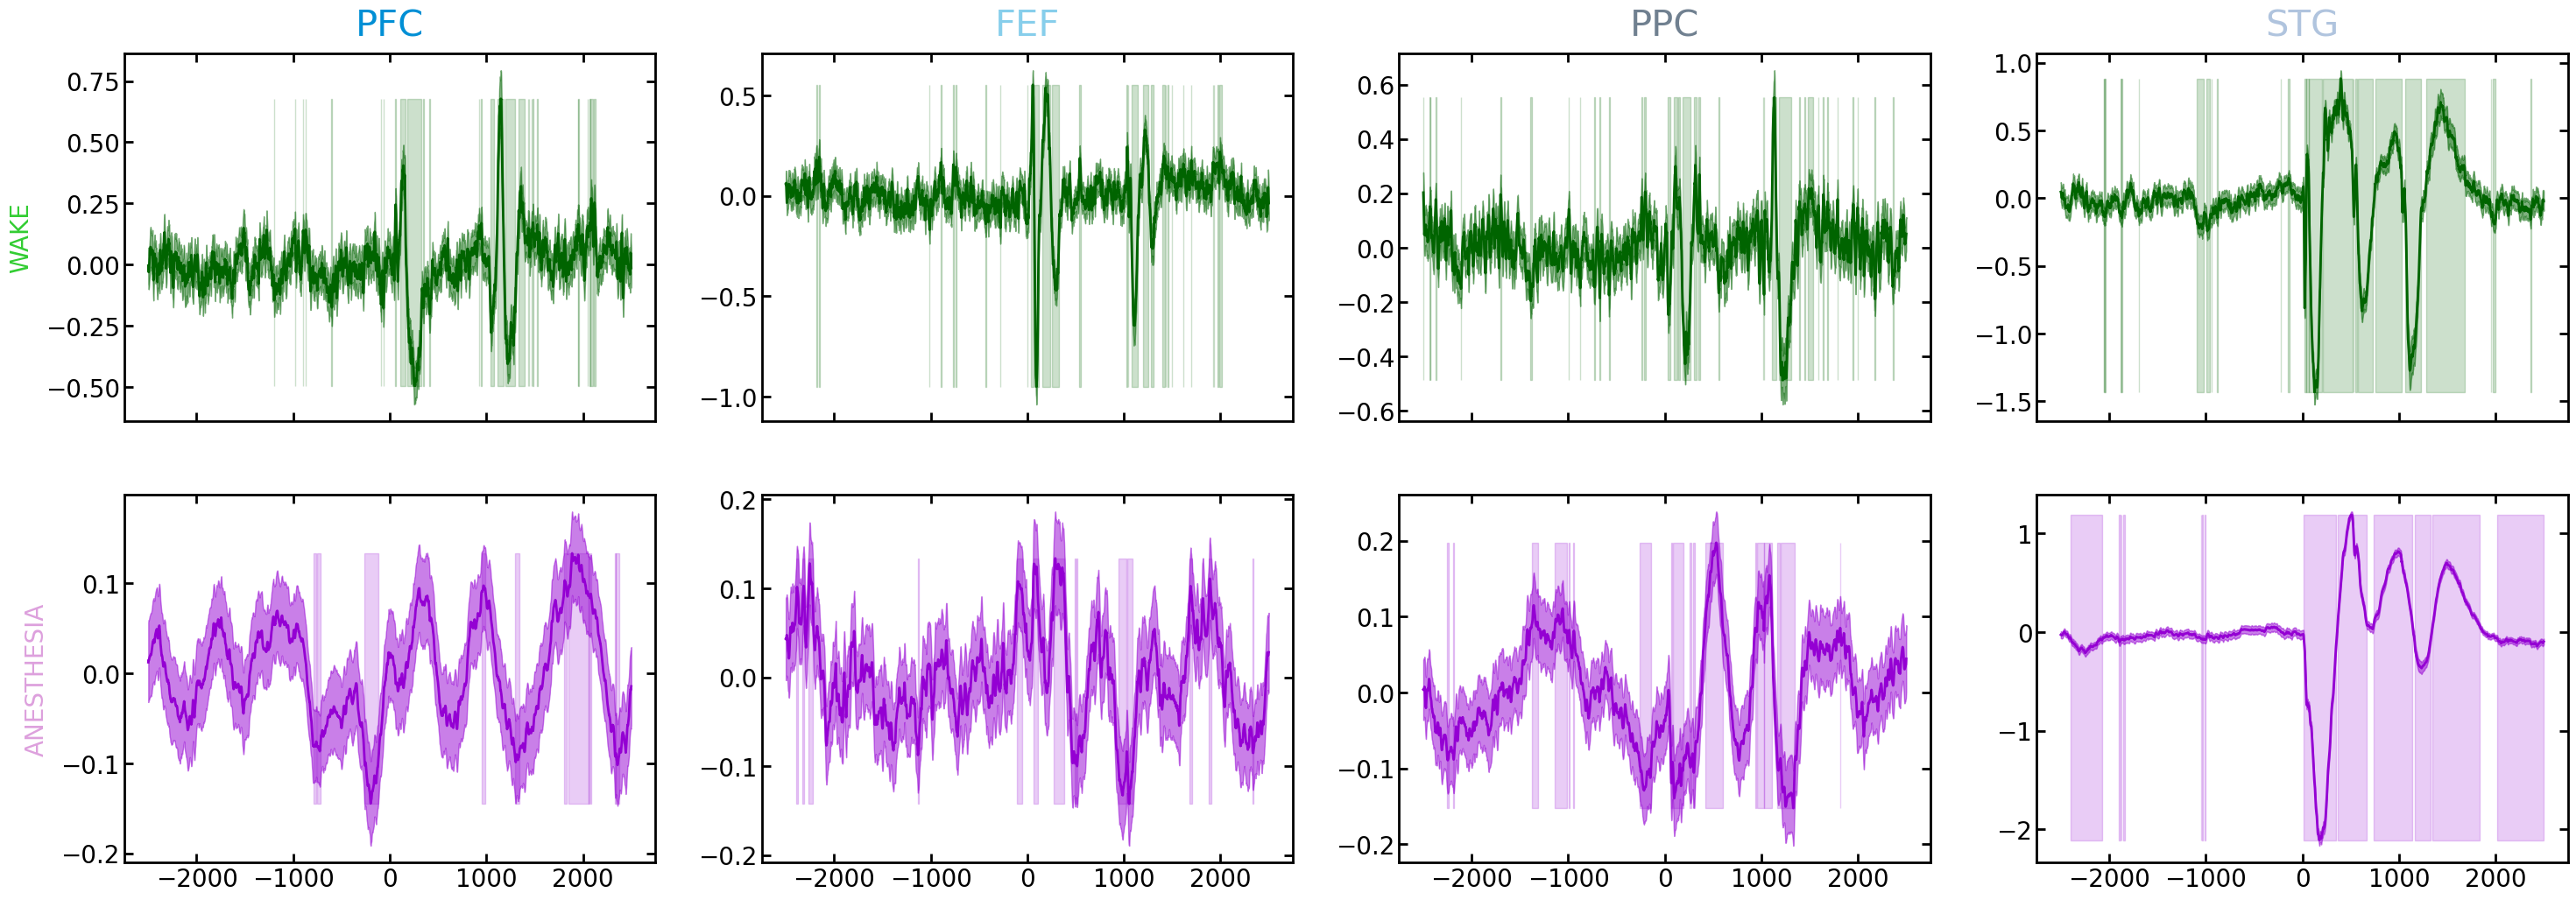

In [147]:
fig, axs = plt.subplots(2, 4, figsize=(36, 12), sharex=True)

start_t = 0
end_t = 5000

for j, section in enumerate(['wake', 'anesthesia']):
    if section == 'wake':
        color = wake_colors[session_num]
    else:
        color = anesthesia_colors[session_num]
    for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):
        ax = axs[j][i]
        area_erp = session_rets[session][f'{section}_erps'][:, :, np.where(session_rets[session]['electrode_info']['area'] == area)[0]]

        if j == 0:
            ax.set_title(area_labels[area], c=area_colors[area], fontsize=30)
        if i== 0:
            if j == 0:
                ax.set_ylabel('WAKE', fontsize=20, c='limegreen')
            else:
                ax.set_ylabel('ANESTHESIA', fontsize=20, c='plum')
        
        p_vals = np.zeros(end_t - start_t)
        for t in np.arange(start_t, end_t):  
        #     p_vals[t - start_t] = scipy.stats.ttest_1samp(area_erps[:, t].flatten(), 0).pvalue
            p_vals[t - start_t] = scipy.stats.ttest_1samp(area_erp[:, t].mean(axis=-1), 0).pvalue
        erp_mean = area_erp.mean(axis=2).mean(axis=0)
        erp_se = area_erp.mean(axis=2).std(axis=0)/(np.sqrt(area_erp.shape[0]))
        ln = ax.plot(time_vals, erp_mean, label=f"{session} - ANESTHESIA", c=color)
        ax.fill_between(time_vals, erp_mean - erp_se, erp_mean + erp_se, color=color, alpha=0.5)
        ax.fill_between(time_vals, erp_mean.min(), erp_mean.max(), where=p_vals <= 0.05, color=color, alpha=0.2)
plt.show()

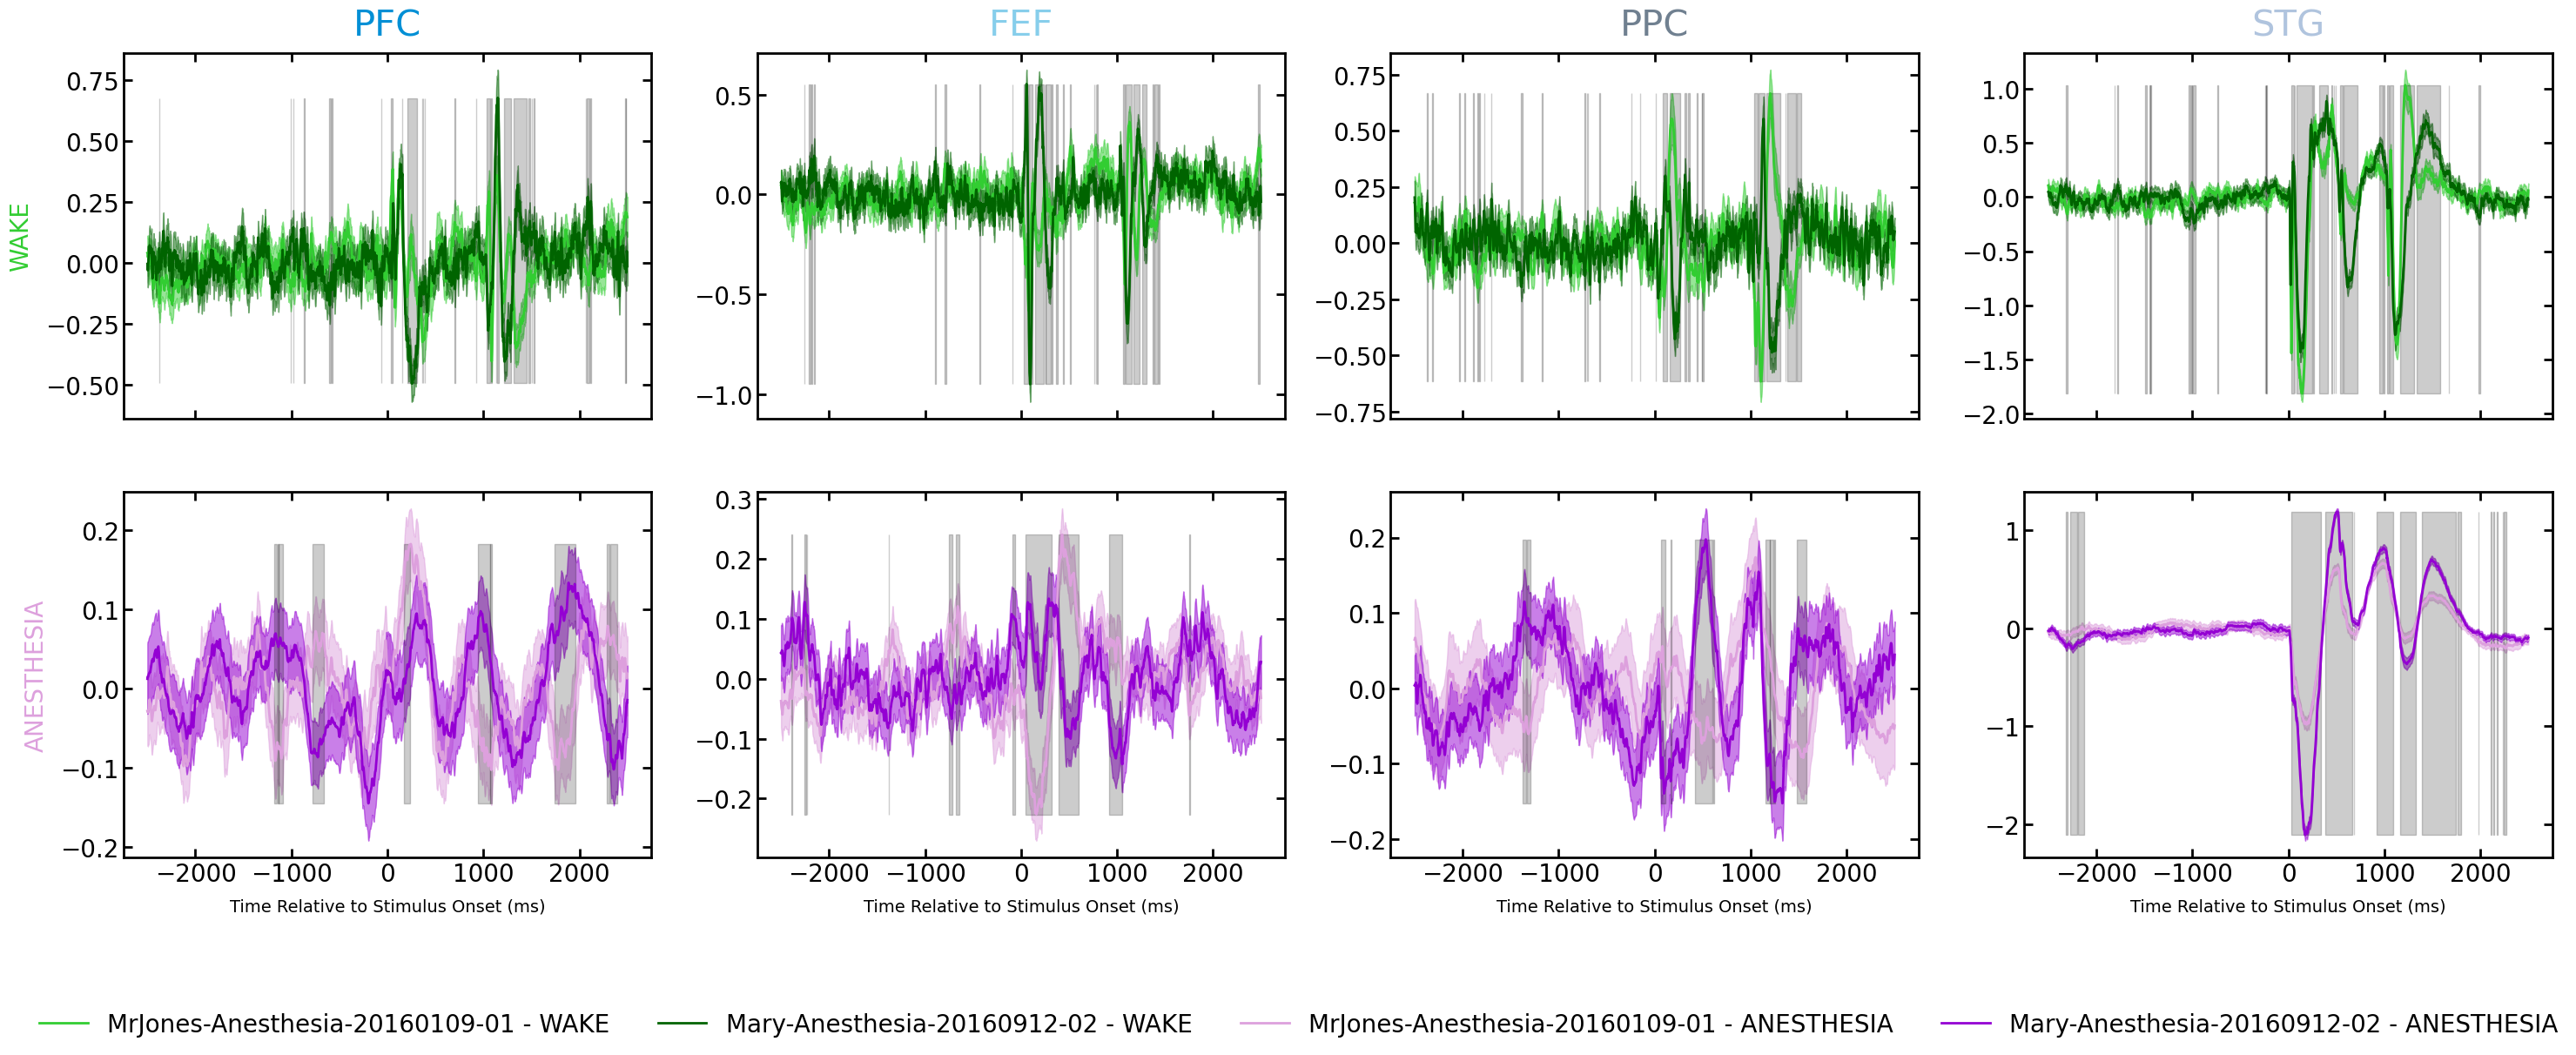

In [142]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'purple'
}
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'all'
}

fig, axs = plt.subplots(2, 4, figsize=(36, 12), sharex=True)

wake_colors = ['limegreen', 'darkgreen']
anesthesia_colors = ['plum', 'darkviolet']

time_vals = np.arange(-leadup, post)
lns = []
for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):
    ax = axs[0][i % 4]
    session_erps = []
    for j, session in enumerate(session_rets.keys()):
        area_erp = session_rets[session]['wake_erps'][:, :, np.where(session_rets[session]['electrode_info']['area'] == area)[0]]
        session_erps.append(area_erp)
#         erp_mean = area_erp.mean(axis=(0, 2))
#         erp_se = area_erp.std(axis=(0, 2))/(np.sqrt(area_erp.shape[0]*area_erp.shape[2]))
        erp_mean = area_erp.mean(axis=2).mean(axis=0)
        erp_se = area_erp.mean(axis=2).std(axis=0)/(np.sqrt(area_erp.shape[0]))
        ln = ax.plot(time_vals, erp_mean, label=f"{session} - WAKE", c=wake_colors[j])
        if i == 0:
            lns += ln
            ax.set_ylabel('WAKE', fontsize=20, c='limegreen')
        ax.fill_between(time_vals, erp_mean - erp_se, erp_mean + erp_se, color=wake_colors[j], alpha=0.5)
    p_vals = np.zeros(end_t - start_t)
    for t in np.arange(start_t, end_t):  
#         p_vals[t - start_t] = scipy.stats.ttest_ind(session_erps[0][:, t].flatten(), session_erps[1][:, t].flatten()).pvalue
        p_vals[t - start_t] = scipy.stats.ttest_ind(session_erps[0][:, t].mean(axis=-1), session_erps[1][:, t].mean(axis=-1)).pvalue
    min_val = np.min([session_erps[0].mean(axis=(0, 2)).min(), session_erps[1].mean(axis=(0, 2)).min()])
    max_val = np.max([session_erps[0].mean(axis=(0, 2)).max(), session_erps[1].mean(axis=(0, 2)).max()])
    ax.fill_between(time_vals, min_val, max_val, where=p_vals <= 0.05, color='k', alpha=0.2)
    ax.set_title(area_labels[area], c=area_colors[area], fontsize=30)
#     ax.legend()
    
for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):
    ax = axs[1][i % 4]
    session_erps = []
    for j, session in enumerate(session_rets.keys()):
        area_erp = session_rets[session]['anesthesia_erps'][:, :, np.where(session_rets[session]['electrode_info']['area'] == area)[0]]
        session_erps.append(area_erp)
        
#         erp_mean = area_erp.mean(axis=(0, 2))
#         erp_se = area_erp.std(axis=(0, 2))/(np.sqrt(area_erp.shape[0]*area_erp.shape[2]))
        erp_mean = area_erp.mean(axis=2).mean(axis=0)
        erp_se = area_erp.mean(axis=2).std(axis=0)/(np.sqrt(area_erp.shape[0]))
        ln = ax.plot(time_vals, erp_mean, label=f"{session} - ANESTHESIA", c=anesthesia_colors[j])
        if i == 0:
            lns += ln
            ax.set_ylabel('ANESTHESIA', fontsize=20, c='plum')
        ax.fill_between(time_vals, erp_mean - erp_se, erp_mean + erp_se, color=anesthesia_colors[j], alpha=0.5)
#     ax.legend()
    p_vals = np.zeros(end_t - start_t)
    for t in np.arange(start_t, end_t):  
#         p_vals[t - start_t] = scipy.stats.ttest_ind(session_erps[0][:, t].flatten(), session_erps[1][:, t].flatten()).pvalue
        p_vals[t - start_t] = scipy.stats.ttest_ind(session_erps[0][:, t].mean(axis=-1), session_erps[1][:, t].mean(axis=-1)).pvalue
    min_val = np.min([session_erps[0].mean(axis=(0, 2)).min(), session_erps[1].mean(axis=(0, 2)).min()])
    max_val = np.max([session_erps[0].mean(axis=(0, 2)).max(), session_erps[1].mean(axis=(0, 2)).max()])
    ax.fill_between(time_vals, min_val, max_val, where=p_vals <= 0.05, color='k', alpha=0.2)
    ax.set_xlabel('Time Relative to Stimulus Onset (ms)', fontsize=14)
fig.legend(lns, [ln.get_label() for ln in lns], fontsize=20, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=4)
plt.show()

In [17]:
area = 'vlPFC'
session_rets[session]['anesthesia_erps'][:, :, np.where(session_rets[session]['electrode_info']['area'] == area)[0]].shape

(407, 5000, 64)

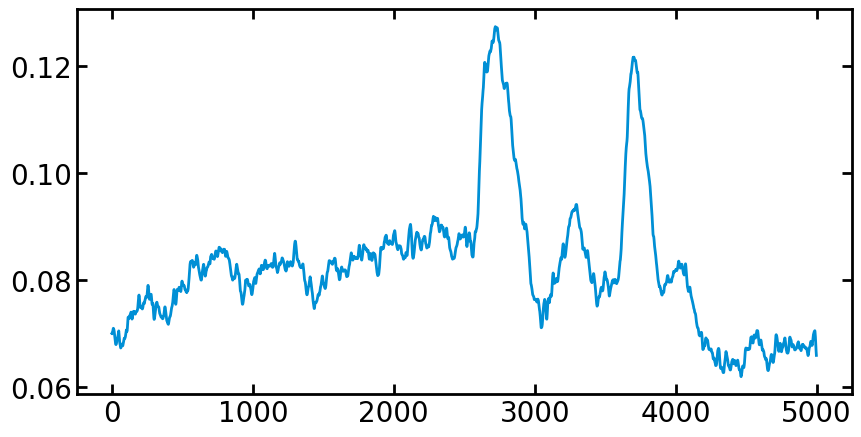

In [125]:
plt.plot(session_rets[session]['anesthesia_erps'][:, :, np.where(session_rets[session]['electrode_info']['area'] == 'CPB')[0]].std(axis=(0, 2)))

# STA

In [10]:
leadup = 2500
post = 2500
for session in session_rets.keys():
    tone_signal = np.zeros(int(session_rets[session]['tone_off'][-1]/dt) + post)
    for i in range(len(session_rets[session]['tone_on'])):
        tone_signal[int(session_rets[session]['tone_on'][i]/dt):int(session_rets[session]['tone_off'][i]/dt)] = 1
    
    unit_stas_wake = []
    unit_stas_anesthesia = []
    n_stas_wake = []
    n_stas_anesthesia = []
    for spike_ts in tqdm(session_rets[session]['spike_times'], total=len(session_rets[session]['spike_times'])):
        unit_stas_wake.append([])
        unit_stas_anesthesia.append([])
        spike_ts = spike_ts[np.logical_and(spike_ts >= session_rets[session]['tone_on'][0], spike_ts <= session_rets[session]['tone_off'][-1])]
        for j, spike_t in enumerate(spike_ts):
            if spike_t >= session_rets[session]['wake_bounds'][0] and spike_t <= session_rets[session]['wake_bounds'][1]:
                unit_stas_wake[-1].append(tone_signal[int(spike_t/dt) - leadup:int(spike_t/dt) + post])
            elif spike_t >= session_rets[session]['anesthesia_bounds'][0] and spike_t <= session_rets[session]['anesthesia_bounds'][1]:
                unit_stas_anesthesia[-1].append(tone_signal[int(spike_t/dt) - leadup:int(spike_t/dt) + post])
        n_stas_wake.append(len(unit_stas_wake[-1]))
        n_stas_anesthesia.append(len(unit_stas_anesthesia[-1]))
        if n_stas_wake[-1] == 0:
            unit_stas_wake[-1] = np.zeros(leadup + post)
        else:
            unit_stas_wake[-1] = np.array(unit_stas_wake[-1]).mean(axis=0)
        if n_stas_anesthesia[-1] == 0:
            unit_stas_anesthesia[-1] = np.zeros(leadup + post)
        else:
            unit_stas_anesthesia[-1] = np.array(unit_stas_anesthesia[-1]).mean(axis=0)
        
    session_rets[session]['unit_stas_wake'] = np.array(unit_stas_wake)
    session_rets[session]['unit_stas_anesthesia'] = np.array(unit_stas_anesthesia)

  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

In [60]:
sessions = list(session_rets.keys())

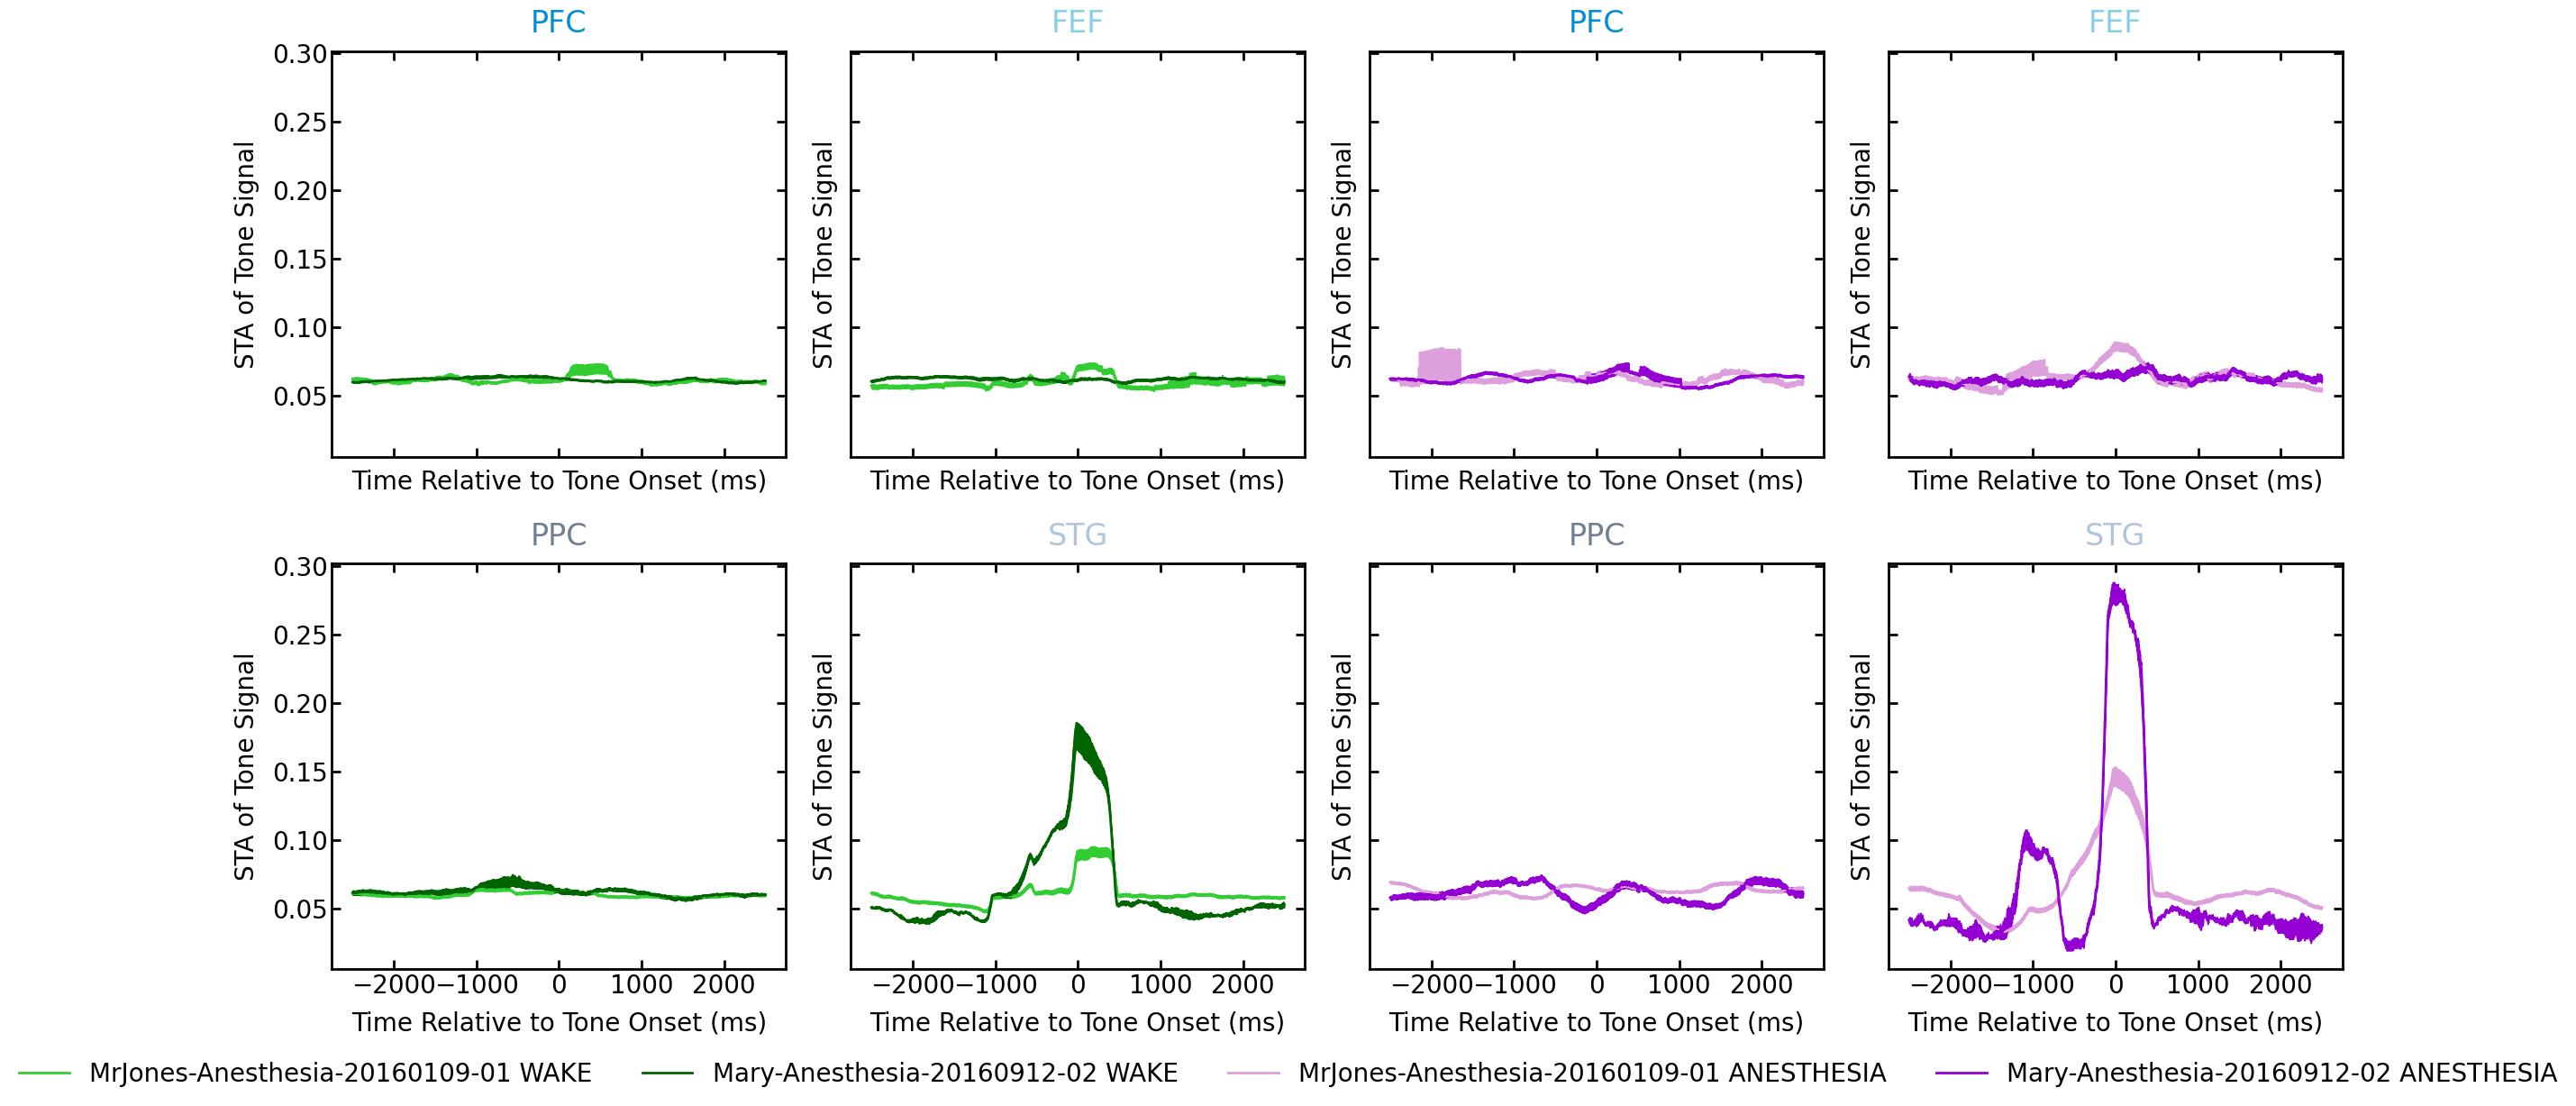

In [81]:
wake_colors = ['limegreen', 'darkgreen']
anesthesia_colors = ['plum', 'darkviolet']
fig, axs = plt.subplots(2, 4, figsize=(24, 12), sharex='col', sharey=True)
lns = []
time_vals = np.arange(-leadup, post)
for i, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB']):
    ax = axs[int(i/2)][i%2]
    for j, session in enumerate(sessions):
        unit_indices = np.where(session_rets[session]['unit_info']['area'] == area)[0]
        sta_mean = session_rets[session]['unit_stas_wake'][unit_indices].mean(axis=0)
        sta_se = session_rets[session]['unit_stas_wake'][unit_indices].std(axis=0)/np.sqrt(len(unit_indices))
        ln = ax.plot(time_vals, sta_mean, c=wake_colors[j], label=f"{session} WAKE")
        ax.fill_between(time_vals, sta_mean - sta_se, sta_mean + sta_se, color=wake_colors[j])
        if i == 0:
            lns += ln
    ax.set_title(area_labels[area], color=area_colors[area])
    ax.set_xlabel('Time Relative to Tone Onset (ms)')
    ax.set_ylabel('STA of Tone Signal')
    ax = axs[int(i/2)][i%2 + 2]
    for j, session in enumerate(sessions):
        unit_indices = np.where(session_rets[session]['unit_info']['area'] == area)[0]
        sta_mean = session_rets[session]['unit_stas_anesthesia'][unit_indices].mean(axis=0)
        sta_se = session_rets[session]['unit_stas_anesthesia'][unit_indices].std(axis=0)/np.sqrt(len(unit_indices))
        ln = ax.plot(time_vals, sta_mean, c=anesthesia_colors[j], label=f"{session} ANESTHESIA")
        ax.fill_between(time_vals, sta_mean - sta_se, sta_mean + sta_se, color=anesthesia_colors[j])
        if i == 0:
            lns += ln
    ax.set_title(area_labels[area], color=area_colors[area])
    ax.set_xlabel('Time Relative to Tone Onset (ms)')
    ax.set_ylabel('STA of Tone Signal')
fig.legend(lns, [ln.get_label() for ln in lns], loc='center', bbox_to_anchor=(0.5, -0.01), ncol=4)
plt.tight_layout()
plt.show()

In [55]:

session_rets[session]['unit_stas_wake']

234

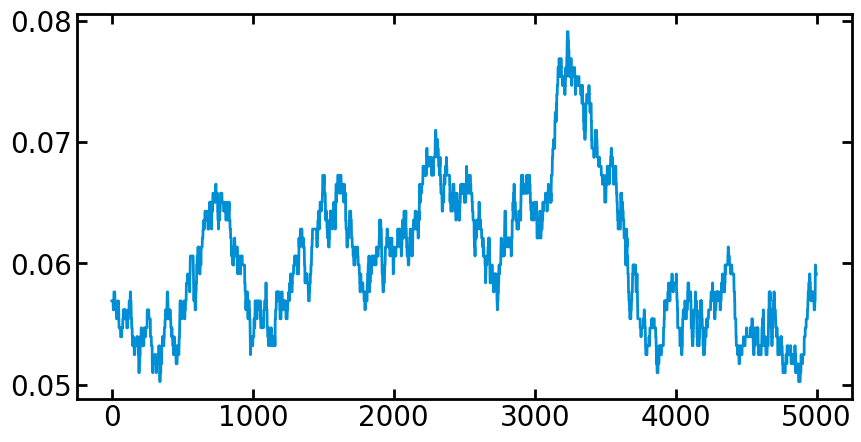

In [15]:
plt.plot(session_rets[session]['unit_stas_wake'][-1])

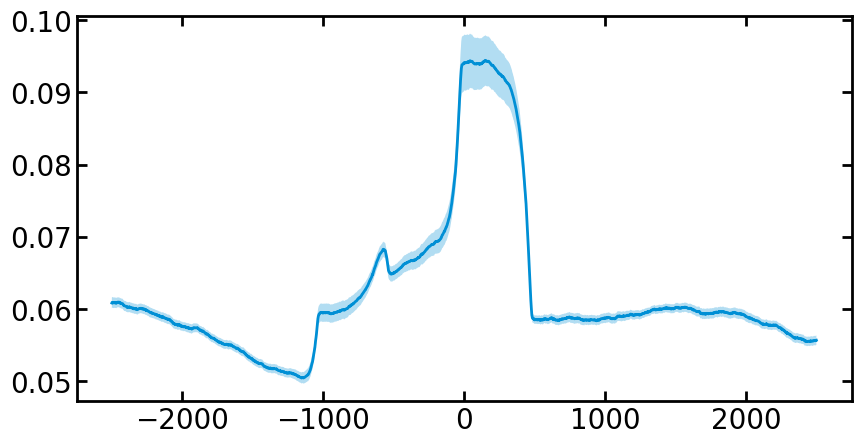

In [205]:
time_vals = np.arange(-leadup, post)
area = 'CPB'
mean_vals = session_rets[session]['unit_sta_means'][np.where(session_rets[session]['unit_info']['area'] == area)[0]].mean(axis=0)
se_vals = session_rets[session]['unit_sta_means'][np.where(session_rets[session]['unit_info']['area'] == area)[0]].std(axis=0)/np.sqrt(session_rets[session]['unit_sta_means'][np.where(session_rets[session]['unit_info']['area'] == area)[0]].shape[0])
plt.plot(time_vals, mean_vals)
plt.fill_between(time_vals, mean_vals - se_vals, mean_vals + se_vals, alpha=0.3)
plt.show()

plt.plot(session_rets[session]['unit_sta_means'][-1])

# pdists

In [31]:
lfp[:15000]

array([[ 0.05905236,  0.00876432, -0.01841297, ..., -0.00303904,
        -0.00265241, -0.00218005],
       [ 0.06330845,  0.02362103, -0.02244303, ..., -0.00685741,
        -0.00522412, -0.0033448 ],
       [ 0.06567864,  0.02442862, -0.02839891, ...,  0.00160581,
        -0.00139036, -0.00169569],
       ...,
       [-0.01767213, -0.03105784, -0.005455  , ..., -0.04185792,
        -0.00419258,  0.0049934 ],
       [-0.01612996, -0.01176285, -0.00582378, ..., -0.02951745,
         0.00359666,  0.01073207],
       [-0.01308374,  0.00952025, -0.00968581, ..., -0.02623446,
         0.00569561,  0.01244115]])

In [ ]:
%%time
pd = pdist(lfp[:120000, np.where(electrode_info['area'] == 'vlPFC')[0]])

In [34]:
pd.argmin()

43043495